# This is the first file for handling my data

In [1]:
import numpy as np
import pylab as plt
from sklearn.neighbors import KDTree
import scipy.linalg as scplinag
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

In [45]:
# Import the data as txt files and then cut them off so we only work with a subset 
dataset = r"C:\Users\noemi\Noemi\UCL Master 2017 2018\Dissertation\CODE\DATA\IQ Mulus\Cassette_idclass\Cassette_GT.txt"
data_whole = np.loadtxt(dataset, delimiter=",", skiprows= 2)

In [128]:
data = data_whole[0:100]

In [136]:
# Define all the columns we have
# As we cut it off at 100: all these arrays are 1D arrays with the shape: (100) (really it would be (1,100))
x = data[:,0]
y = data[:,1]
z = data[:,2]
inst_id = data[:,3]
obj_class = data[:,4]
# If we want to access one element, we just write: x[0]

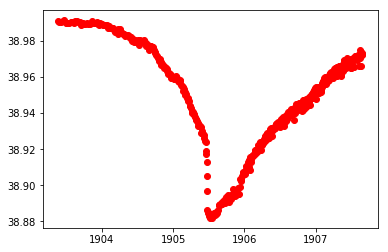

([<matplotlib.lines.Line2D at 0x13571cb70>], None)

In [48]:
# First visualisation in 2D
plt.plot(x,z,'ro'), plt.show()

In [49]:
# This is the dataset but only with the coordinates (either 3D or 2D for testing)
dataxyz = data[:,0:3]
dataxy = data[:, 0:2]

In [67]:
# This gives different results so check later 
# This is the old version, dont use that anymore, the results are wrong 

def covarianceMatrix(data):
    """
    Function to compute the covariance matrix.
    
    Input: Dataset of 3D points; i.e. array of dimension: #points x 3 
    Output: 3x3 covariance matrix (np.array)
    
    Alternatively, use the numpy command: np.cov(x,y)
    """
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]

    C = np.zeros((data.shape[1], data.shape[1]))
    
    if x.size != y.size or x.size != z.size:
        print "X, Y and Z must be of same dimensions."
    else:
        for i in range(C.shape[0]):
            for j in range(C.shape[1]):
                for pnt in data:
                    # For each point, access x and y in all combinations (xx, xy, yx, yy)
                    C[i][j] = C[i][j] + pnt[i]*pnt[j]
            
        C = (1/float(x.size)) * C
        
    return C

In [223]:
# Right coordinates
def computeCovarianceMatrix(data):
    """
    Function to compute the covariance matrix.
    
    Input: Dataset of 3D points; i.e. array of dimension: #points x 3 
    Output: 3x3 covariance matrix (np.array)
    """
    # Create covariance matrix and array to store the mean values for x_mean, y_mean, z_mean
    C = np.zeros((data.shape[1], data.shape[1]))
    mean_xyz = []
    # Calculate all mean values
    for i in range(0, dataxyz.shape[1]):
        mean_xyz.append(dataxyz[:,i].mean())
    mean_xyz = np.array(mean_xyz)
    # Check whether dimensions agree 
    if dataxyz[:,0].size != dataxyz[:,1].size or dataxyz[:,0].size != dataxyz[:,2].size:
        print "X, Y and Z must be of same dimensions."
    else:
        # For each row in covariance matrix C
        for i in range(0, C.shape[0]):
            # For each column in covariance matrix C
            for j in range(0, C.shape[1]):
                C[i,j] = 0
                # For each point in the dataset, access x, y, z-values
                for point in dataxyz:
                    # For each point, access x,y and z in all combinations (xx, xy, xz, yx, yy, yz etc)
                    C[i][j] = C[i][j] + (point[i]-mean_xyz[i])*(point[j]-mean_xyz[j])
    # Divide by the total number of points                
    C = (1.0/dataxyz.shape[0]) * C
    return C 

In [224]:
computeCovarianceMatrix(dataxyz)

array([[ 7.44,  5.68,  3.92],
       [ 5.68,  4.56,  3.44],
       [ 3.92,  3.44,  2.96]])

In [71]:
# Get eight parameters for each point

def calcFeatureDescr(covarianceMatrix):
    """
    Function to compute the 8 feature descriptors for each point.
    
    Input: 3x3 Covariance matrix of a point and its neighbourhood 
    
    Output: Array with feature descriptors as described by Weinmann et al. (1D array with 8 elements)
    
    """
    D, V = scplinag.eigh(C)
    # We sort the array with eigenvalues by size (from smallest to largest value)
    D.sort()
    # Get eigenvectors
    e1 = V[2] # eigenvector in direction of largest variance
    e2 = V[1] # second eigenvector, perpend. to e1
    e3 = V[0]
    # Find the eigenvalues
    evalue1 = D[2] # largest
    evalue2 = D[1]
    evalue3 = D[0] # smallest

    # Linearity
    lambda1 = (evalue1 - evalue2) / evalue1
    # Planarity
    lambda2 = (evalue2 - evalue3) / evalue1
    # Scattering
    lambda3 = evalue3 / evalue1
    # Omnivariance
    lambda4 = pow(evalue1*evalue2*evalue3, 1/3.0)
    # Anisotropy
    lambda5 = (evalue1 - evalue3) / evalue1
    # Eigentropy
    s = 0
    for elem in D:
        s = s + (elem*np.log(elem))
    lambda6 = (-1)*s  
    # Sum of eigenvalues
    lambda7 = sum(D)
    # Change of curvature
    lambda8 = evalue3/sum(D) 
    
    featureDescriptor = np.array([lambda1, lambda2, lambda3, lambda4, lambda5, lambda6, lambda7, lambda8])
    return featureDescriptor

In [72]:
# For the covariance matrix, compute the feature descriptor 
featDesc8 = calcFeatureDescr(C)

In [73]:
# This step follows Demantke rather than Weinmann and we find out first whether the features are linear, planar or volumetric 
# For now we only look at the first three elements of the feature descriptor 
featDesc3 = featDesc8[0:3]

In [74]:
dominantDim = np.argmax(featDesc3)
if dominantDim == 0:
    print "Linear feature"
elif dominantDim == 1:
    print "Planar feature"
else:
    print "Volumetric feature"

Linear feature


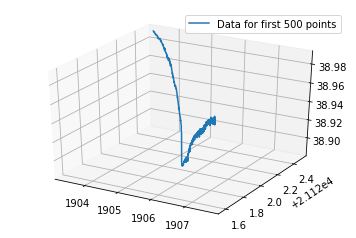

In [87]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z, label='Data for first '+ str(data.shape[0]) +' points')
ax.legend()
plt.show()

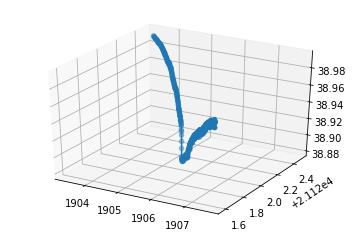

In [90]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter3D(x,y,z,zdir='z')
ax.plot(x, y, z, label='Data for first '+ str(data.shape[0]) +' points')
plt.show()

# From here on testing, continue with Script: DissTest3

In [ ]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

In [92]:
kdt = KDTree(X, leaf_size=30, metric='euclidean')
tree = KDTree(X, leaf_size=2)

In [102]:
kdt.query(X, k=4, return_distance=True)

(array([[ 0.        ,  1.        ,  2.23606798,  2.82842712],
        [ 0.        ,  1.        ,  1.41421356,  3.60555128],
        [ 0.        ,  1.41421356,  2.23606798,  5.        ],
        [ 0.        ,  1.        ,  2.23606798,  2.82842712],
        [ 0.        ,  1.        ,  1.41421356,  3.60555128],
        [ 0.        ,  1.41421356,  2.23606798,  5.        ]]),
 array([[0, 1, 2, 3],
        [1, 0, 2, 3],
        [2, 1, 0, 3],
        [3, 4, 5, 0],
        [4, 3, 5, 0],
        [5, 4, 3, 0]], dtype=int64))

In [109]:
idx = tree.query([X[0]], k=4, return_distance=False)    


In [113]:
print idx[0]

[0 1 2 3]


In [226]:
tree = KDTree(data, leaf_size=20)
for point_idx in range(0, data.shape[0]):
    idx = tree.query([data[0]], k=2, return_distance=False)
    store = []
    for i in idx[0]:
        store.append(data[i])
    store = np.array(store)
    C = covarianceMatrix(store)
    
        
    

In [121]:
store = []
for count in range(0,5):
    store.append(X[count])
store = np.array(store)